<a href="https://colab.research.google.com/github/tesko211/well-log/blob/main/WellLogs_Porosity_Perm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q lasio scikit-learn
# allow wget (already present) and requests
import os, glob, sys
import requests
import lasio
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

plt.rcParams['figure.figsize'] = (9,5)
print("Cell 1 done: packages installed and imports ready.")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 2.0 MB/s eta 0:00:00
Cell 1 done: packages installed and imports ready.


In [2]:
# Cell 2 — download files from GitHub repo (teacher's links -> raw content)
repo_user = "tesko211"
repo_name = "well-log"
branch = "main"   # teacher used main in links

filenames = ["A10","A15","A16","B2","B4","B8","B9","C1","C2","C3","C4","C5"]

outdir = "/content/github_files"
os.makedirs(outdir, exist_ok=True)

raw_base = f"https://raw.githubusercontent.com/{repo_user}/{repo_name}/{branch}/"

downloaded = []
for name in filenames:
    # try common variants/extensions: .las, .LAS, .csv, no extension
    tried = []
    success = False
    for ext in [".las", ".LAS", ".csv", ""]:
        url = raw_base + name + ext
        tried.append(url)
        try:
            r = requests.get(url, timeout=20)
            if r.status_code == 200 and len(r.content) > 0:
                # save file
                # If no extension in URL but content-disposition may exist — we keep ext as found
                outpath = os.path.join(outdir, name + (ext if ext else ""))
                with open(outpath, "wb") as f:
                    f.write(r.content)
                downloaded.append(outpath)
                print(f"Downloaded: {url} -> {outpath} (size={os.path.getsize(outpath)} bytes)")
                success = True
                break
        except Exception as e:
            pass
    if not success:
        print(f"WARNING: Could not download {name}. Tried URLs:\n  " + "\n  ".join(tried))

print("\nDownload complete. Files in folder:")
print(sorted(os.listdir(outdir)))


Downloaded: https://raw.githubusercontent.com/tesko211/well-log/main/A10 -> /content/github_files/A10 (size=147863 bytes)
Downloaded: https://raw.githubusercontent.com/tesko211/well-log/main/A15 -> /content/github_files/A15 (size=45223 bytes)
Downloaded: https://raw.githubusercontent.com/tesko211/well-log/main/A16 -> /content/github_files/A16 (size=57143 bytes)
Downloaded: https://raw.githubusercontent.com/tesko211/well-log/main/B2 -> /content/github_files/B2 (size=186822 bytes)
Downloaded: https://raw.githubusercontent.com/tesko211/well-log/main/B4 -> /content/github_files/B4 (size=202982 bytes)
Downloaded: https://raw.githubusercontent.com/tesko211/well-log/main/B8 -> /content/github_files/B8 (size=94822 bytes)
Downloaded: https://raw.githubusercontent.com/tesko211/well-log/main/B9 -> /content/github_files/B9 (size=202742 bytes)
Downloaded: https://raw.githubusercontent.com/tesko211/well-log/main/C1 -> /content/github_files/C1 (size=75702 bytes)
Downloaded: https://raw.githubusercont

In [3]:
# Cell 3 — inspect files and detect type (LAS vs CSV)
folder = "/content/github_files"
files = sorted(os.listdir(folder))
info = []
for f in files:
    path = os.path.join(folder, f)
    size = os.path.getsize(path)
    kind = "unknown"
    # quick check: if file starts with "~Version" or "VERS." or "# LAS" -> LAS
    with open(path, "rb") as fh:
        head = fh.read(512).decode(errors='ignore').lower()
    if "las" in f.lower() or head.startswith('# las') or "version" in head and "well" in head:
        kind = "las"
    else:
        # try reading as CSV header
        try:
            sample = pd.read_csv(path, nrows=3)
            kind = "csv"
        except Exception:
            kind = "unknown"
    info.append((f, kind, size))
print("Files detected (name, type, bytes):")
for it in info:
    print(it)


Files detected (name, type, bytes):
('A10', 'las', 147863)
('A15', 'las', 45223)
('A16', 'las', 57143)
('B2', 'las', 186822)
('B4', 'las', 202982)
('B8', 'las', 94822)
('B9', 'las', 202742)
('C1', 'las', 75702)
('C2', 'las', 88422)
('C3', 'las', 94182)
('C4', 'las', 122102)
('C5', 'las', 86582)


In [4]:
# Cell 4 — read files (LAS -> lasio.df, CSV -> pd.read_csv), then concat
folder = "/content/github_files"
paths = sorted([os.path.join(folder, f) for f in os.listdir(folder)])
dfs = []
for p in paths:
    fname = os.path.basename(p)
    try:
        if fname.lower().endswith('.las'):
            las = lasio.read(p)
            df_temp = las.df()         # index typically is depth
            df_temp = df_temp.reset_index()
            df_temp['__source_file'] = fname
            dfs.append(df_temp)
            print("Read LAS:", fname, "shape:", df_temp.shape)
        elif fname.lower().endswith('.csv'):
            df_temp = pd.read_csv(p)
            df_temp['__source_file'] = fname
            dfs.append(df_temp)
            print("Read CSV:", fname, "shape:", df_temp.shape)
        else:
            # try to read as las first, then csv
            tried = False
            try:
                las = lasio.read(p)
                df_temp = las.df().reset_index()
                df_temp['__source_file'] = fname
                dfs.append(df_temp)
                print("Read (auto) LAS:", fname, "shape:", df_temp.shape)
                tried = True
            except Exception:
                pass
            if not tried:
                try:
                    df_temp = pd.read_csv(p)
                    df_temp['__source_file'] = fname
                    dfs.append(df_temp)
                    print("Read (auto) CSV:", fname, "shape:", df_temp.shape)
                except Exception as e:
                    print("ERROR reading file", fname, ":", e)
    except Exception as e:
        print("ERROR reading", fname, ":", e)

if not dfs:
    raise RuntimeError("No files were read successfully. Check previous output.")

# Combine
df = pd.concat(dfs, ignore_index=True, sort=False)
print("\nCombined df shape:", df.shape)
print("Columns:", list(df.columns)[:80])


Read (auto) LAS: A10 shape: (1835, 7)
Read (auto) LAS: A15 shape: (552, 7)
Read (auto) LAS: A16 shape: (701, 7)
Read (auto) LAS: B2 shape: (2322, 7)
Read (auto) LAS: B4 shape: (2524, 7)
Read (auto) LAS: B8 shape: (1172, 7)
Read (auto) LAS: B9 shape: (2521, 7)
Read (auto) LAS: C1 shape: (933, 7)
Read (auto) LAS: C2 shape: (1092, 7)
Read (auto) LAS: C3 shape: (1164, 7)
Read (auto) LAS: C4 shape: (1513, 7)
Read (auto) LAS: C5 shape: (1069, 7)

Combined df shape: (17398, 7)
Columns: ['DEPT', 'GAMMA', 'PERM', 'POROSITY', 'RESISTIVITY', 'LITH', '__source_file']


In [5]:
# Cell 5 — coerce to numeric where possible and display columns
cols = [c for c in df.columns if c != '__source_file']
for c in cols:
    df[c] = pd.to_numeric(df[c], errors='coerce')

print("Columns available:")
print(list(df.columns))
print("\nQuick numeric summary (first 30 cols):")
display(df[cols].describe().T.head(30))


Columns available:
['DEPT', 'GAMMA', 'PERM', 'POROSITY', 'RESISTIVITY', 'LITH', '__source_file']

Quick numeric summary (first 30 cols):


,count,mean,std,min,25%,50%,75%,max
DEPT,17398.0,2132.168185,296.879840,1467.488300,1929.900300,2113.496100,2326.749400,2991.917100
GAMMA,17342.0,85.631054,20.820116,20.037910,74.117769,83.013752,92.082531,159.749725
PERM,17342.0,0.001362,0.001521,0.000006,0.000544,0.000996,0.001671,0.029556
POROSITY,17335.0,0.001589,0.000569,0.000000,0.001150,0.001461,0.002109,0.003289
RESISTIVITY,17329.0,6.948060,39.065088,0.000272,0.418047,1.425442,4.321900,2252.267578
LITH,17333.0,1.599550,0.829981,0.000000,1.000000,1.000000,2.000000,3.000000


In [6]:
# Cell 6 — auto-detect porosity & permeability columns
def first_match(keywords):
    for k in keywords:
        for c in df.columns:
            if k in str(c).lower():
                return c
    return None

por = first_match(['phie','phit','porosity','poro','phi'])
perm = first_match(['permeability','perm','kperm','perm_','perme'])

# fallback for single-letter 'K'
if perm is None:
    for c in df.columns:
        if str(c).strip().lower() == 'k':
            perm = c
            break

print("Auto-detected por:", por)
print("Auto-detected perm:", perm)
if por is None or perm is None:
    print("\nAuto-detection failed for one or both targets.")
    print("Paste the EXACT column name here to set manually (copy it from the printed column list).")


Auto-detected por: POROSITY
Auto-detected perm: PERM


In [7]:
# Cell 7 — pick features and clean dataset
preferred = ['GR','RHOB','NPHI','DT','RT','ILM','ILD','SP']
features = [c for c in preferred if c in df.columns]

# fallback: take up to 6 numeric columns excluding targets and __source_file
if len(features) < 2:
    candidate = [c for c in df.select_dtypes(include=[np.number]).columns if c not in (por, perm, '__source_file')]
    features = candidate[:6]

print("Features selected:", features)
# require targets present
df_targets = df.dropna(subset=[por, perm]).copy()
print("Rows with both targets:", len(df_targets))
if len(df_targets) < 50:
    raise RuntimeError("Too few rows with both targets present. Check por/perm names or files.")

# impute features median if necessary
if df_targets[features].isna().sum().sum() > 0:
    imputer = SimpleImputer(strategy='median')
    df_targets[features] = imputer.fit_transform(df_targets[features])
    print("Features imputed (median).")

df_clean = df_targets.reset_index(drop=True)
print("df_clean shape:", df_clean.shape)
display(df_clean[features + [por, perm]].head())


Features selected: ['DEPT', 'GAMMA', 'RESISTIVITY', 'LITH']
Rows with both targets: 17333
Features imputed (median).
df_clean shape: (17333, 7)


,DEPT,GAMMA,RESISTIVITY,LITH,POROSITY,PERM
0,1501.629,78.869453,0.709644,3.0,0.002674,0.001246
1,1502.129,78.008301,0.790188,3.0,0.002561,0.001253
2,1502.629,75.581558,0.780511,3.0,0.002421,0.001171
3,1503.129,73.238037,0.706579,3.0,0.002386,0.001096
4,1503.629,71.504173,0.661791,3.0,0.002384,0.001060


In [8]:
# Cell 8 — prepare arrays, scale, and split once
X = df_clean[features].values
y_por = df_clean[por].values
y_perm = df_clean[perm].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_por_train, y_por_test, y_perm_train, y_perm_test = train_test_split(
    X_scaled, y_por, y_perm, test_size=0.20, random_state=42
)

print("Shapes:")
print(" X_train", X_train.shape, "X_test", X_test.shape)
print(" y_por_train", y_por_train.shape, "y_por_test", y_por_test.shape)


Shapes:
 X_train (13866, 4) X_test (3467, 4)
 y_por_train (13866,) y_por_test (3467,)


In [9]:
# Cell 9 — train models
lr_por = LinearRegression().fit(X_train, y_por_train)
rf_por = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1).fit(X_train, y_por_train)

lr_perm = LinearRegression().fit(X_train, y_perm_train)
rf_perm = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1).fit(X_train, y_perm_train)

print("Models trained.")


Models trained.


Porosity - LR: {'r2': 0.8770507643048915, 'rmse': 0.0001994581639916138, 'mae': 0.00015290583023094628}
Porosity - RF: {'r2': 0.9535165803371373, 'rmse': 0.00012264163610876068, 'mae': 8.432073852986574e-05}
Permeability - LR: {'r2': 0.5436233043232176, 'rmse': 0.0010615487457736284, 'mae': 0.0005601472713601626}
Permeability - RF: {'r2': 0.9636016740495118, 'rmse': 0.0002997912249439022, 'mae': 0.00010918429999829325}


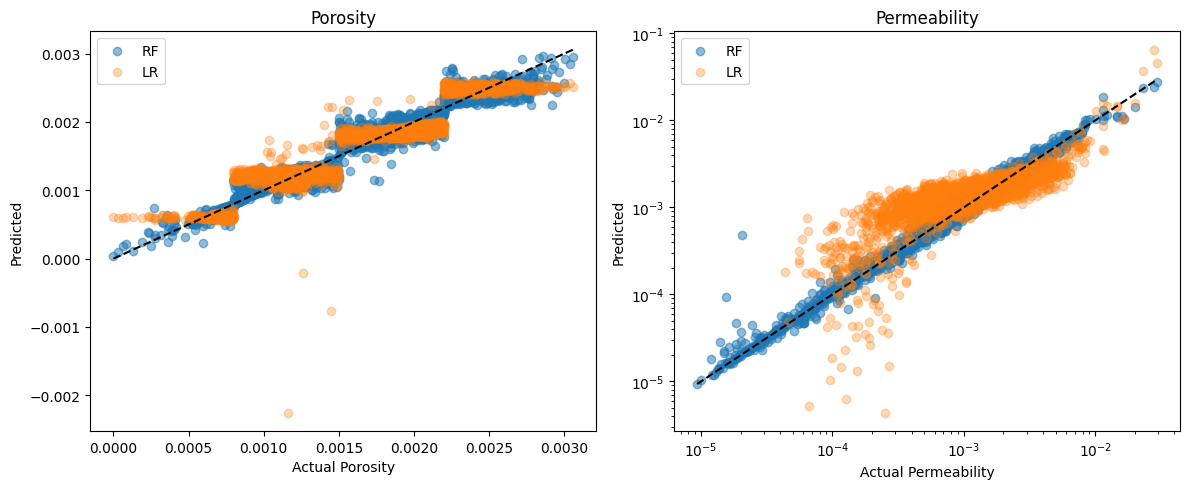

In [11]:
# Cell 10 — evaluate & plot (compatible with older scikit-learn)
def metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = mse ** 0.5
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return {"r2": float(r2), "rmse": float(rmse), "mae": float(mae)}

y_por_pred_lr = lr_por.predict(X_test)
y_por_pred_rf = rf_por.predict(X_test)
y_perm_pred_lr = lr_perm.predict(X_test)
y_perm_pred_rf = rf_perm.predict(X_test)

print("Porosity - LR:", metrics(y_por_test, y_por_pred_lr))
print("Porosity - RF:", metrics(y_por_test, y_por_pred_rf))
print("Permeability - LR:", metrics(y_perm_test, y_perm_pred_lr))
print("Permeability - RF:", metrics(y_perm_test, y_perm_pred_rf))

# --- Plots ---
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.scatter(y_por_test, y_por_pred_rf, alpha=0.5, label='RF')
plt.scatter(y_por_test, y_por_pred_lr, alpha=0.3, label='LR')
plt.plot([min(y_por_test), max(y_por_test)], [min(y_por_test), max(y_por_test)], 'k--')
plt.xlabel("Actual Porosity"); plt.ylabel("Predicted"); plt.legend(); plt.title("Porosity")

plt.subplot(1,2,2)
plt.scatter(y_perm_test, y_perm_pred_rf, alpha=0.5, label='RF')
plt.scatter(y_perm_test, y_perm_pred_lr, alpha=0.3, label='LR')
try:
    plt.xscale('log'); plt.yscale('log')
except:
    pass
plt.plot([max(1e-9,min(y_perm_test)), max(y_perm_test)],
         [max(1e-9,min(y_perm_test)), max(y_perm_test)], 'k--')
plt.xlabel("Actual Permeability"); plt.ylabel("Predicted"); plt.legend(); plt.title("Permeability")
plt.tight_layout()
plt.show()


In [12]:
# Cell 11 — save results to Drive
from google.colab import drive
drive.mount('/content/drive')  # follow link & paste code

out_dir = "/content/drive/MyDrive/WellLogs_Project"
os.makedirs(out_dir, exist_ok=True)

# Save models and scaler
joblib.dump(rf_por, os.path.join(out_dir, 'rf_porosity.joblib'))
joblib.dump(rf_perm, os.path.join(out_dir, 'rf_permeability.joblib'))
joblib.dump(scaler, os.path.join(out_dir, 'scaler.joblib'))

# Save predictions
predictions = pd.DataFrame({
    'Actual_Porosity': y_por_test,
    'Pred_Porosity_RF': y_por_pred_rf,
    'Pred_Porosity_LR': y_por_pred_lr,
    'Actual_Perm': y_perm_test,
    'Pred_Perm_RF': y_perm_pred_rf,
    'Pred_Perm_LR': y_perm_pred_lr
})
predictions.to_csv(os.path.join(out_dir, 'predictions.csv'), index=False)
print("Saved models and predictions to Drive:", out_dir)

# To save the notebook to GitHub: Colab menu -> File -> Save a copy in GitHub (choose your repo & path)
print("Now use Colab: File -> Save a copy in GitHub to push notebook to your repository.")


Mounted at /content/drive
Saved models and predictions to Drive: /content/drive/MyDrive/WellLogs_Project
Now use Colab: File -> Save a copy in GitHub to push notebook to your repository.


In [13]:
# Final summary
print("✅ Training complete. Final model scores:")
print("Porosity - RandomForest R²:", metrics(y_por_test, y_por_pred_rf)['r2'])
print("Permeability - RandomForest R²:", metrics(y_perm_test, y_perm_pred_rf)['r2'])


✅ Training complete. Final model scores:
Porosity - RandomForest R²: 0.9535165803371373
Permeability - RandomForest R²: 0.9636016740495118


In [14]:
joblib.dump(rf_por, "RF_Porosity_Model.pkl")
joblib.dump(rf_perm, "RF_Permeability_Model.pkl")


['RF_Permeability_Model.pkl']

Possible porosity columns: ['POROSITY']
Possible permeability columns: ['PERM']
✅ Porosity column: POROSITY
✅ Permeability column: PERM


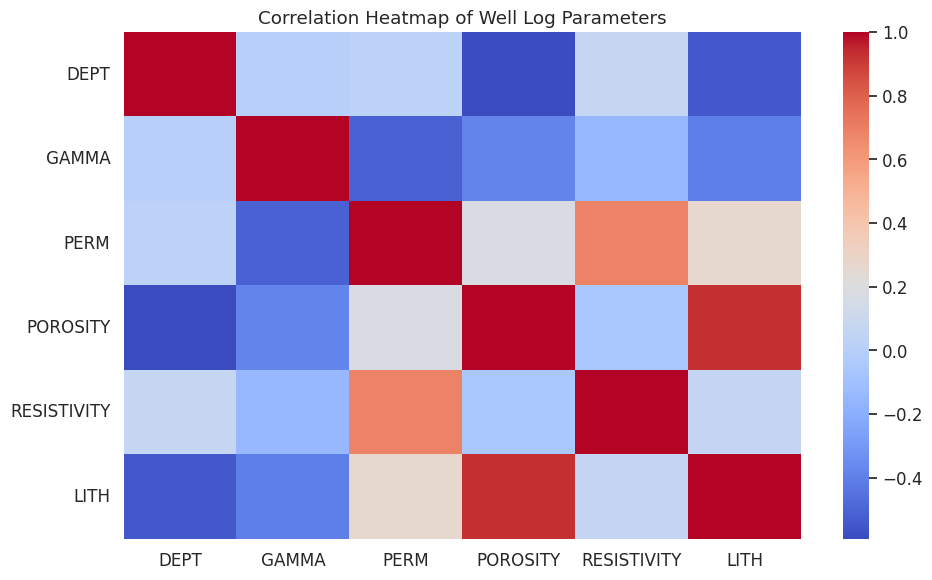

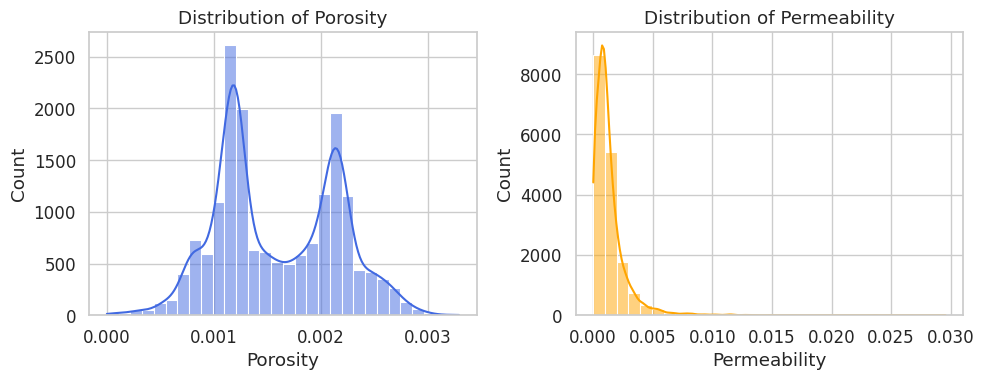

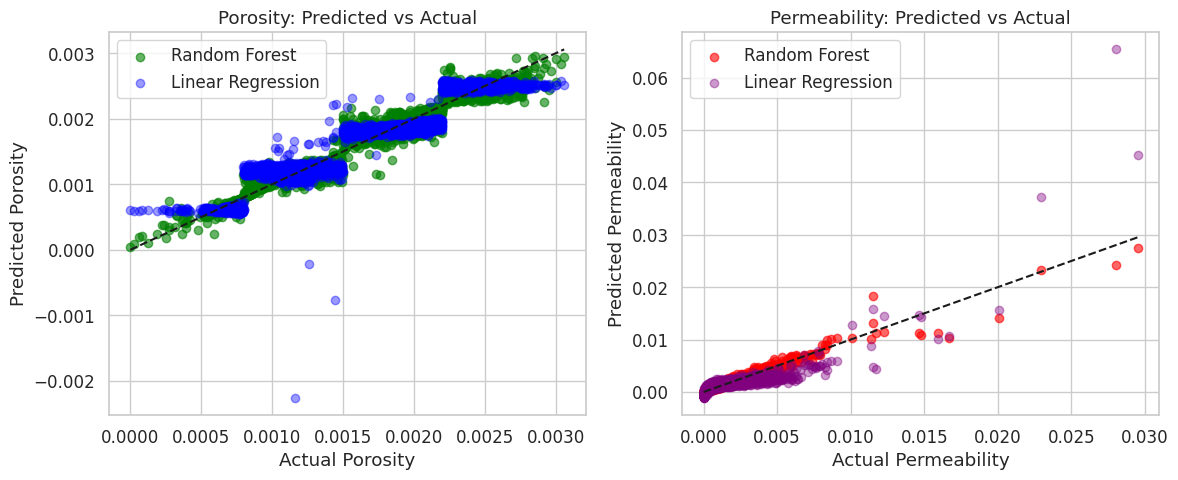

/tmp/ipython-input-3705359463.py:89: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feat_imp, x='Importance', y='Feature', palette='viridis')


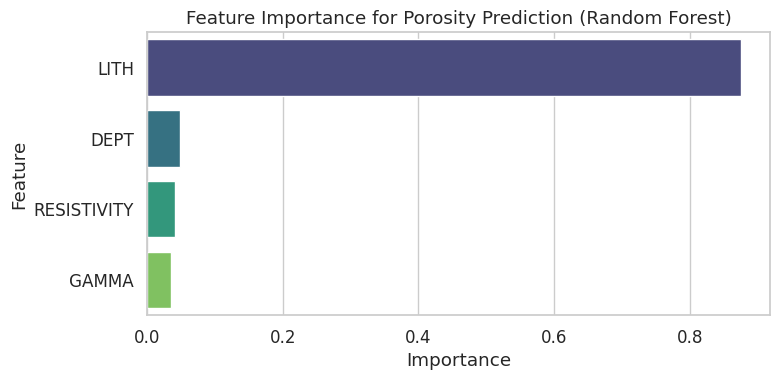

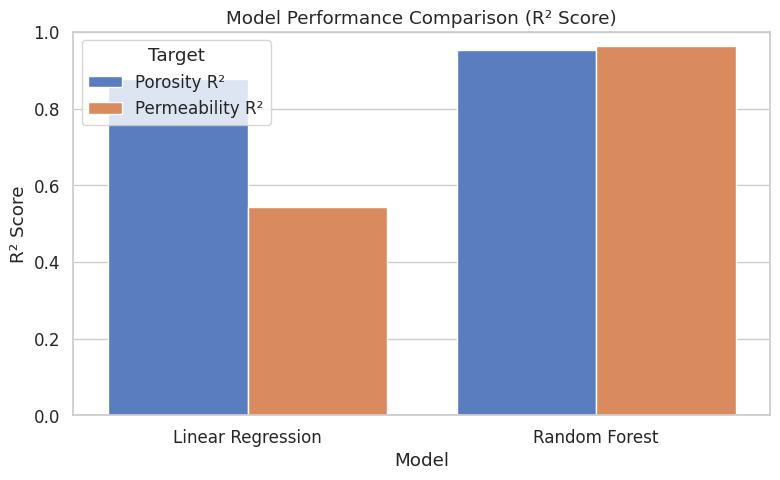

✅ All visualization steps completed successfully!
🖼️ All images saved in /content/ as PNG files. You can download them from the Files tab.


In [18]:
# ======================================================
# 📊 STEP 1 — Import visualization libraries
# ======================================================
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import r2_score

sns.set(style="whitegrid", palette="muted", font_scale=1.1)

# ======================================================
# ✅ STEP 2 — Define porosity & permeability columns
# ======================================================
# If you already defined them earlier, this will skip redefining
if "por_col" not in globals():
    # Automatically detect or ask for confirmation
    possible_por_cols = [c for c in df.columns if "phi" in c.lower() or "por" in c.lower()]
    possible_perm_cols = [c for c in df.columns if "perm" in c.lower() or c.lower() == "k"]
    print("Possible porosity columns:", possible_por_cols)
    print("Possible permeability columns:", possible_perm_cols)

    por_col = possible_por_cols[0] if possible_por_cols else input("Enter porosity column name: ")
    perm_col = possible_perm_cols[0] if possible_perm_cols else input("Enter permeability column name: ")

print("✅ Porosity column:", por_col)
print("✅ Permeability column:", perm_col)

# ======================================================
# 📈 STEP 3 — Correlation heatmap of numeric features
# ======================================================
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(numeric_only=True), cmap="coolwarm", annot=False)
plt.title("Correlation Heatmap of Well Log Parameters")
plt.tight_layout()
plt.savefig("/content/Correlation_Heatmap.png", dpi=300, bbox_inches='tight')
plt.show()

# ======================================================
# 📉 STEP 4 — Histogram / Distribution of Porosity & Permeability
# ======================================================
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
sns.histplot(df_clean[por_col], bins=30, kde=True, color='royalblue')
plt.xlabel("Porosity")
plt.title("Distribution of Porosity")

plt.subplot(1,2,2)
sns.histplot(df_clean[perm_col], bins=30, kde=True, color='orange')
plt.xlabel("Permeability")
plt.title("Distribution of Permeability")

plt.tight_layout()
plt.savefig("/content/Porosity_Permeability_Distribution.png", dpi=300, bbox_inches='tight')
plt.show()

# ======================================================
# 🪶 STEP 5 — Predicted vs Actual Scatterplots
# ======================================================
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.scatter(y_por_test, y_por_pred_rf, alpha=0.6, label='Random Forest', color='green')
plt.scatter(y_por_test, y_por_pred_lr, alpha=0.4, label='Linear Regression', color='blue')
plt.plot([min(y_por_test), max(y_por_test)], [min(y_por_test), max(y_por_test)], 'k--')
plt.xlabel("Actual Porosity"); plt.ylabel("Predicted Porosity")
plt.legend(); plt.title("Porosity: Predicted vs Actual")

plt.subplot(1,2,2)
plt.scatter(y_perm_test, y_perm_pred_rf, alpha=0.6, label='Random Forest', color='red')
plt.scatter(y_perm_test, y_perm_pred_lr, alpha=0.4, label='Linear Regression', color='purple')
plt.plot([min(y_perm_test), max(y_perm_test)], [min(y_perm_test), max(y_perm_test)], 'k--')
plt.xlabel("Actual Permeability"); plt.ylabel("Predicted Permeability")
plt.legend(); plt.title("Permeability: Predicted vs Actual")

plt.tight_layout()
plt.savefig("/content/Predicted_vs_Actual.png", dpi=300, bbox_inches='tight')
plt.show()

# ======================================================
# 🌳 STEP 6 — Feature Importance (Random Forest)
# ======================================================
try:
    importances = rf_por.feature_importances_
    feat_imp = pd.DataFrame({'Feature': features, 'Importance': importances})
    feat_imp = feat_imp.sort_values(by='Importance', ascending=False)

    plt.figure(figsize=(8,4))
    sns.barplot(data=feat_imp, x='Importance', y='Feature', palette='viridis')
    plt.title("Feature Importance for Porosity Prediction (Random Forest)")
    plt.tight_layout()
    plt.savefig("/content/Feature_Importance_Porosity.png", dpi=300, bbox_inches='tight')
    plt.show()
except Exception as e:
    print("⚠️ Feature importance not available:", e)

# ======================================================
# 🧮 STEP 7 — Model Performance Comparison (R²)
# ======================================================
results = pd.DataFrame({
    "Model": ["Linear Regression", "Random Forest"],
    "Porosity R²": [
        r2_score(y_por_test, y_por_pred_lr),
        r2_score(y_por_test, y_por_pred_rf)
    ],
    "Permeability R²": [
        r2_score(y_perm_test, y_perm_pred_lr),
        r2_score(y_perm_test, y_perm_pred_rf)
    ]
})

results_melted = results.melt(id_vars="Model", var_name="Target", value_name="R² Score")

plt.figure(figsize=(8,5))
sns.barplot(data=results_melted, x="Model", y="R² Score", hue="Target")
plt.title("Model Performance Comparison (R² Score)")
plt.ylim(0,1)
plt.tight_layout()
plt.savefig("/content/Model_Performance_Comparison.png", dpi=300, bbox_inches='tight')
plt.show()

print("✅ All visualization steps completed successfully!")
print("🖼️ All images saved in /content/ as PNG files. You can download them from the Files tab.")
